# Spectral Centroid

Plot [spectral centroid](https://ccrma.stanford.edu/workshops/mir2009/juans_lecture/3_feature.pdf) at specific loudness level.

In [15]:
import sys
sys.path.append('..')

In [16]:
import warnings
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)

In [17]:
import IPython.display as display
import librosa
import matplotlib.pyplot as plot
import numpy as np

from philharmonia import dataframe, datafile

In [18]:
import pyloudnorm

meter = None

def loudness(sample):

    x, sr = librosa.load(datafile(sample.file), sr=None, mono=True)

    global meter
    meter = meter or pyloudnorm.Meter(sr, block_size=100e-3)

    db = meter.integrated_loudness(x)

    return int(db)

In [19]:
def centroid(sample, relative=False):

    x, sr = librosa.load(datafile(sample.file), sr=None, mono=True)

    magn = np.abs(np.fft.rfft(x * np.hanning(x.size))) ** 2
    freq = np.fft.rfftfreq(x.size) * sr
    cent = np.sum(freq * magn) / np.sum(magn)

    if relative:

        freq = (freq - cent) ** 2
        cent = np.sqrt(np.sum(freq * magn) / np.sum(magn))

    return round(cent, 2)

In [20]:
query = [
    "(family == 'brass' | family == 'woodwind')",
    "style == 'normal'",
    "length == '1'",
]

filter = ['file', 'instrument', 'pitch']
sort = ['instrument', 'loudness', 'centroid']

data = dataframe().query(' & '.join(query)).filter(filter)

data['loudness'] = data.apply(lambda sample: loudness(sample), axis=1)
data['centroid'] = data.apply(lambda sample: centroid(sample), axis=1)

data = data.groupby(['instrument', 'loudness'])['centroid'].mean().round(2).reset_index()

data = data.sort_values(sort)

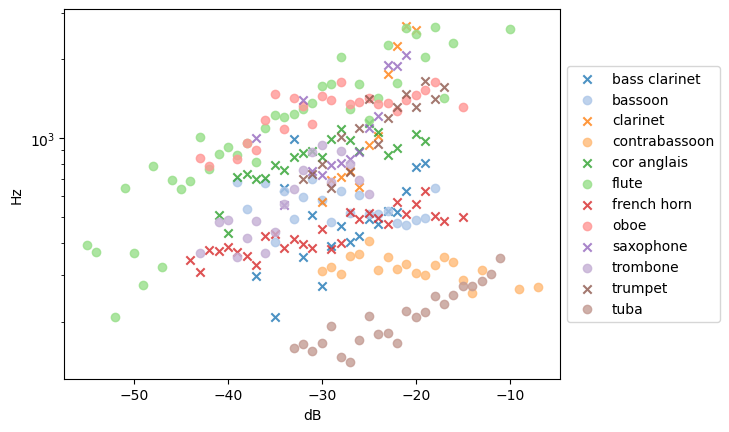

In [21]:
import matplotlib

colors = matplotlib.cm.get_cmap('tab20')
markers = ['x', 'o']

instruments = sorted(data.instrument.unique())

for i, instrument in enumerate(instruments):

    records = data[data.instrument == instrument]

    x = records.loudness.tolist()
    y = records.centroid.tolist()

    plot.scatter(x, y, label=instrument, marker=markers[i%2], color=colors(i), alpha=0.8)

plot.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plot.yscale('log');
plot.xlabel('dB');
plot.ylabel('Hz');

In [22]:
display.HTML(data.to_html())

,instrument,loudness,centroid
0,bass clarinet,-37,297.53
1,bass clarinet,-35,208.64
2,bass clarinet,-34,648.08
3,bass clarinet,-33,993.29
4,bass clarinet,-32,353.82
5,bass clarinet,-31,509.92
6,bass clarinet,-30,273.85
7,bass clarinet,-29,389.96
8,bass clarinet,-28,463.94
9,bass clarinet,-27,403.74
